In [5]:
!pip install contractions

In [180]:
import zipfile
import re
import os
import time
import string
import glob
import random
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
import tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle
import contractions
import numpy as np
import nltk
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as tl, optimizers as topt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

In [7]:
# root_dir = "/content/drive/My Drive/"

# project_folder = "DataSets"

# def create_and_set_working_directory(project_folder):

#   if os.path.isdir(root_dir + project_folder) == False:
#     os.mkdir(root_dir + project_folder)
#     print(root_dir + project_folder + ' did not exist but was created.')

#   os.chdir(root_dir + project_folder)


# create_and_set_working_directory(project_folder)
# create_and_set_working_directory(project_folder+'/Flicker')

In [8]:
# ## Data Loading Phase(in Drive)
# ############################## Use Only first time
# !wget --no-check-certificate \
#     "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip" \
#     -O "/content/drive/My Drive/DataSets/Flicker/Flickr8k_Dataset.zip"


# zip_ref = zipfile.ZipFile('/content/drive/My Drive/DataSets/Flicker/Flickr8k_Dataset.zip', 'r') #Opens the zip file in read mode
# zip_ref.extractall('/content/drive/My Drive/DataSets/Flicker/Flickr8k_Dataset') #Extracts the files into the /tmp folder
# zip_ref.close()

In [9]:
# # Data Loading Phase(in Drive)

# ############################### Use Only one time
# !wget --no-check-certificate \
#     "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip" \
#     -O "/content/drive/My Drive/DataSets/Flicker/Flickr8k_text.zip"


# zip_ref = zipfile.ZipFile('/content/drive/My Drive/DataSets/Flicker/Flickr8k_text.zip', 'r') #Opens the zip file in read mode
# zip_ref.extractall('/content/drive/My Drive/DataSets/Flicker/Flickr8k_text') #Extracts the files into the /tmp folder
# zip_ref.close()

In [10]:
# Constants
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
root_direction = "/content/drive/My Drive/DataSets"
punc_chars = r'!"#\$%&\'()\*+,-\.\/:;<=>?@\[\]\^_`{\|}~'

In [11]:
all_image_names = os.listdir(os.path.join(root_direction,'Flicker/Flickr8k_Dataset/Flicker8k_Dataset'))
TRAIN_PATH, DEV_PATH, TEST_PATH = os.path.join(root_direction,'Flicker/Flickr8k_text/Flickr_8k.trainImages.txt'), os.path.join(root_direction,'Flicker/Flickr8k_text/Flickr_8k.devImages.txt'),os.path.join(root_direction,'Flicker/Flickr8k_text/Flickr_8k.testImages.txt') 
Train_Images, Dev_Images, Test_Images = [],[],[]
with open(TRAIN_PATH, 'r') as f:
  Train_ImageNames = f.read().strip().split('\n')
with open(DEV_PATH, 'r') as f:
  Dev_ImageNames = f.read().strip().split('\n')
with open(TEST_PATH, 'r') as f:
  Test_ImageNames = f.read().strip().split('\n')

for image_name in all_image_names:
  if image_name in Train_ImageNames: 
    Train_Images.append(image_name)
  if image_name in Dev_ImageNames: 
    Dev_Images.append(image_name) 
  elif image_name in Test_ImageNames:
    Test_Images.append(image_name)

In [12]:
print(len(all_image_names), " !!! ", len(Train_Images)," !!! ", len(Dev_Images), " !!! " , len(Test_Images))

8091  !!!  6000  !!!  1000  !!!  1000


In [13]:
def Initialize_text_data(root_direction):
  with open(os.path.join(root_direction, 'Flicker/Flickr8k_text/Flickr8k.token.txt')) as f:
    lines = f.readlines()
  return lines

def Split_text_data(descriptions, train_names, dev_names, test_names):
  train_descriptions, test_descriptions = [], []
  for desc in descriptions:
    image_name = desc.split('#')[0]
    
    if (image_name in train_names) or (image_name in dev_names):
      train_descriptions.append(desc)
    elif image_name in test_names:
      test_descriptions.append(desc)
  return train_descriptions, test_descriptions

def line_normalization(line):
  pic_type, text = line.split('\t')
  pic_name, _ = pic_type.split('.jpg')
  text = line.lower()
  text = contractions.fix(text)
  text = re.sub(punc_chars, '', text)
  text = re.sub(' +', ' ', text)
  words = text.split(" ")
  words = [word for word in words if len(words) > 1]
  words = [word for word in words if word.isalpha()]
  words.insert(0,'aghaz')
  words.insert(len(words), 'payan')

  return pic_name, words,len(words)


def Normalize_text_data(descriptions):
  distinct_tokens, pic_descriptions, max_words = set(), defaultdict(lambda : list()), 0
  for index,des in enumerate(descriptions):
    pic_name, words, des_length = line_normalization(des)
    normalized_des = ' '.join(words)
    max_words = max(max_words, des_length)
    pic_descriptions[pic_name].append(normalized_des)
    distinct_tokens.update(words)

  return distinct_tokens, pic_descriptions, max_words


In [14]:
descriptions = Initialize_text_data(root_direction)
descriptions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n'

In [15]:
train_descriptions, test_descriptions = Split_text_data(descriptions, Train_Images, Dev_Images, Test_Images)
distinct_tokens, text_data, maxlen_des = Normalize_text_data(train_descriptions)
test_distinct_tokens, test_text_data, test_maxlen_des = Normalize_text_data(test_descriptions)

In [16]:
len(train_descriptions)

35000

In [17]:
print(distinct_tokens)

{'branding', 'crouching', 'quarterback', 'puddles', 'peers', 'griding', 'egde', 'kissing', 'ac', 'snowfall', 'and', 'unison', 'checkout', 'sprinkler', 'amount', 'swinger', 'picture', 'captures', 'hate', 'addressing', 'cage', 'snarling', 'skiing', 'transportation', 'mom', 'cream', 'canooers', 'braiding', 'hortons', 'challenging', 'entertaining', 'buffet', 'very', 'rubs', 'audience', 'repels', 'wicker', 'marks', 'white', 'alligator', 'stalks', 'cropped', 'leotard', 'docked', 'dine', 'cruise', 'passin', 'woolen', 'applauding', 'marching', 'blower', 'plays', 'geishas', 'noisemaker', 'official', 'reflects', 'monitors', 'huts', 'changes', 'sundress', 'clear', 'companions', 'disc', 'seventh', 'another', 'trim', 'shovels', 'shady', 'gives', 'graduation', 'climber', 'prestends', 'substance', 'binocular', 'hang', 'bust', 'chews', 'licked', 'untouched', 'lunch', 'upstream', 'traffic', 'bring', 'object', 'crouched', 'fives', 'poor', 'polo', 'clasp', 'cresting', 'unsual', 'mickey', 'basett', 'crash

In [18]:
print(len(distinct_tokens), " @@@ \n", len(text_data), " @@@\n", maxlen_des)

7672  @@@ 
 7000  @@@
 35


In [19]:
text_data[list(text_data.keys())[0]]

['aghaz child in a pink dress is climbing up a set of stairs in an entry way payan',
 'aghaz girl going into a wooden building payan',
 'aghaz little girl climbing into a wooden playhouse payan',
 'aghaz little girl climbing the stairs to her playhouse payan',
 'aghaz little girl in a pink dress going into a wooden cabin payan']

In [20]:
list(text_data.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [21]:
len(train_descriptions)

35000

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

In [23]:
def ConvertImage(picture, preprocess_input, encode_model):
  pic = picture.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  pic = tensorflow.keras.preprocessing.image.img_to_array(pic)
  pic = np.expand_dims(pic, axis=0)
  pic = preprocess_input(pic)
  pic = encode_model.predict(pic) 
  pic = np.reshape(pic, OUTPUT_DIM )
  return pic

def get_preprocessed_images(Pictures, image_type): #either 'train', or 'test'
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
  PPI_Path, hash_table = os.path.join(root_direction,'Flicker/PreprocessedImages/{}.pickle'), {}
  if not os.path.exists(os.path.join(root_direction,'Flicker/PreprocessedImages/{}.pickle'.format(image_type))):
    if not os.path.exists(os.path.join(root_direction,'Flicker/PreprocessedImages')):
      os.mkdir(os.path.join(root_direction,'Flicker/PreprocessedImages'))
    for image in tqdm(Pictures):
      ppi = tensorflow.keras.preprocessing.image.load_img(os.path.join(root_direction,'Flicker/Flickr8k_Dataset/Flicker8k_Dataset',image), target_size=(HEIGHT, WIDTH))
      hash_table[image] = ConvertImage(ppi, preprocess_input, encode_model)

    with open(PPI_Path.format(image_type),'wb') as f:
      pickle.dump(hash_table, f)
  else:
    with open(PPI_Path.format(image_type),'rb') as f:
      hash_table  = pickle.load(f)

  return hash_table


In [24]:
TrainDev = list(Train_Images)
TrainDev.extend(Dev_Images)

In [25]:
pstart = time.time()
train_ppi, test_ppi = get_preprocessed_images(TrainDev, 'train'), get_preprocessed_images(Test_Images, 'test')
pend = time.time()
print(pend-pstart)

7.194279670715332


# Combining Data

In [26]:
TrainDev = []
for index, photo in enumerate(list(train_ppi.keys())):
  tmp = photo.split('.jpg')[0]
  for i, seq in enumerate(text_data[tmp]):
    TrainDev.append((photo,seq))

In [27]:
all_traindev_caps, CAPTION = [], 1
for pair in TrainDev:
  all_traindev_caps.append(pair[CAPTION])

In [28]:
all_traindev_caps[:10]

['aghaz child in a pink dress is climbing up a set of stairs in an entry way payan',
 'aghaz girl going into a wooden building payan',
 'aghaz little girl climbing into a wooden playhouse payan',
 'aghaz little girl climbing the stairs to her playhouse payan',
 'aghaz little girl in a pink dress going into a wooden cabin payan',
 'aghaz black dog and a spotted dog are payan',
 'aghaz black dog and a dog playing with each other on the road payan',
 'aghaz black dog and a white dog with brown spots are staring at each other in the street payan',
 'aghaz dogs of different breeds looking at each other on the road payan',
 'aghaz dogs on pavement moving toward each other payan']

In [29]:
from keras.preprocessing.text import Tokenizer

In [30]:
def get_vocab_word_threshold_mapping(texts, word_count_threshold):
  keras_tokenizer = Tokenizer()
  keras_tokenizer.fit_on_texts(texts)
  vocab = [pair[0] for pair in dict(keras_tokenizer.word_counts).items() if pair[1] >= word_count_threshold]
  prev_size = len(dict(keras_tokenizer.word_counts))

  updated_texts = []

  for sequence in texts:
    sequence = (" ").join([token for token in sequence.split(" ") if token in vocab])
    updated_texts.append(sequence)

  text_tokenizer = Tokenizer()
  text_tokenizer.fit_on_texts(updated_texts)
  text_mappings = text_tokenizer.texts_to_sequences(updated_texts)

  return text_mappings, vocab, text_tokenizer, prev_size

In [31]:
all_train_mappings, vocabulary, text_tokenizer, prev_size = get_vocab_word_threshold_mapping(all_traindev_caps, 8)

In [32]:
all_train_mappings[:10]

[[1, 43, 4, 3, 85, 169, 7, 116, 50, 3, 402, 12, 397, 4, 34, 670, 2],
 [1, 18, 299, 59, 3, 188, 119, 2],
 [1, 39, 18, 116, 59, 3, 188, 2],
 [1, 39, 18, 116, 5, 397, 19, 58, 2],
 [1, 39, 18, 4, 3, 85, 169, 299, 59, 3, 188, 2],
 [1, 14, 9, 8, 3, 781, 9, 15, 2],
 [1, 14, 9, 8, 3, 9, 32, 10, 131, 81, 6, 5, 153, 2],
 [1, 14, 9, 8, 3, 13, 9, 10, 24, 996, 15, 596, 21, 131, 81, 4, 5, 75, 2],
 [1, 30, 12, 782, 82, 21, 131, 81, 6, 5, 153, 2],
 [1, 30, 6, 712, 804, 311, 131, 81, 2]]

In [33]:
print(prev_size, " ====> ", len(vocabulary))

7672  ====>  2025


In [34]:
max_len = max([len(seq) for seq in all_train_mappings])

In [35]:
max_len

34

In [36]:
all_train_mappings = pad_sequences(all_train_mappings, maxlen = max_len, padding = 'post')

In [37]:
all_train_mappings[:5]

array([[  1,  43,   4,   3,  85, 169,   7, 116,  50,   3, 402,  12, 397,
          4,  34, 670,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  18, 299,  59,   3, 188, 119,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  39,  18, 116,  59,   3, 188,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  39,  18, 116,   5, 397,  19,  58,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  39,  18,   4,   3,  85, 169, 299,  59,   3, 188,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [38]:
Pretest_data = []
for index, photo in enumerate(list(train_ppi.keys())):
  for i in range(5):
    Pretest_data.append((train_ppi[photo], all_train_mappings[((index*5)+i)]))

In [39]:
Pretest_data[:5]

[(array([0.12277575, 0.33294842, 0.75271666, ..., 0.21939674, 0.3021641 ,
         0.4028326 ], dtype=float32),
  array([  1,  43,   4,   3,  85, 169,   7, 116,  50,   3, 402,  12, 397,
           4,  34, 670,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)),
 (array([0.12277575, 0.33294842, 0.75271666, ..., 0.21939674, 0.3021641 ,
         0.4028326 ], dtype=float32),
  array([  1,  18, 299,  59,   3, 188, 119,   2,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)),
 (array([0.12277575, 0.33294842, 0.75271666, ..., 0.21939674, 0.3021641 ,
         0.4028326 ], dtype=float32),
  array([  1,  39,  18, 116,  59,   3, 188,   2,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)),
 (array([0.12277575, 0.33

# Spliting data into Train and Dev Sets

In [40]:
def Shuffler(data, train_size):
  data_size = len(data)
  # train_samples = random.sample(data,train_size)
  # dev_samples = [sample for sample in data if sample not in train_samples]
  train_samples, dev_samples = [],[]

  sample_indices = random.sample(list(range(data_size)), train_size)
  for index in range(data_size):
    if index in sample_indices:
      train_samples.append(data[index])
    else:
      dev_samples.append(data[index])

  return train_samples, dev_samples


In [41]:
TRAIN_PHOTO_SIZE = 6000
X_train , X_dev = Shuffler(Pretest_data, TRAIN_PHOTO_SIZE * 5)

In [42]:
print(len(X_train)," ### ", len(X_dev))

30000  ###  5000


# Generator

In [43]:
def data_generator(data, num_photos_per_batch):
  photos, descriptions = [item[0] for item in data], [item[1] for item in data]
  train_photo, text_data, target_word, current_batch_size = [], [], [], 0
  while True:
    for index in range(5):
      sequence = descriptions[(current_batch_size*5) + index]
      for i in range(1, len(sequence)):
        in_seq, out_seq = [sequence[:i]], [sequence[i]]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        photo = np.array(photos[index])
        train_photo.append(photo)
        in_seq = pad_sequences(in_seq, maxlen = len(sequence), padding = 'post')[0]
        text_data.append(np.array(in_seq))
        target_word.append(np.array(out_seq))
    current_batch_size += 1
    if current_batch_size == num_photos_per_batch:
      yield ([np.array(train_photo), np.array(text_data)], np.array(target_word))
      train_photo, text_data, target_word, current_batch_size = [], [], [], 0
      
def data_creator(data, num_photos_per_batch):
  photos, descriptions = [item[0] for item in data], [item[1] for item in data]
  train_photo, text_data, target_word, current_batch_size = [], [], [], 0
  for index in range(len(descriptions)):
    sequence = descriptions[index]
    for i in range(1, len(sequence)):
      in_seq, out_seq = [sequence[:i]], [sequence[i]]
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      photo = np.array(photos[index])
      train_photo.append(photo)
      in_seq = pad_sequences(in_seq, maxlen = len(sequence), padding = 'post')[0]
      text_data.append(np.array(in_seq))
      target_word.append(np.array(out_seq))
  current_batch_size += 1
  return ([np.array(train_photo), np.array(text_data)], np.array(target_word))

# Load Embeddings

In [44]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [45]:
############################# Use Only first time
# !wget --no-check-certificate \
#     "http://nlp.stanford.edu/data/glove.6B.zip" \
#     -O "/content/drive/My Drive/Embeddings/glove.6B.zip"


# zip_ref = zipfile.ZipFile('/content/drive/My Drive/Embeddings/glove.6B.zip', 'r') #Opens the zip file in read mode
# zip_ref.extractall('/content/drive/My Drive/Embeddings/Glove') #Extracts the files into the /tmp folder
# zip_ref.close()

In [46]:
glove_dir = '/content/drive/My Drive/Embeddings/Glove'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:24, 16449.84it/s]

Found 400000 word vectors.


In [47]:
embedding_dim = 200
vocab_size = len(vocabulary)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in dict(text_tokenizer.word_index).items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i-1] = embedding_vector

# Neural Network Functional API Implementation

In [48]:
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import add, LSTM, Embedding, Dense, Activation, Flatten, Dropout

In [49]:
photoInput = Input(shape=(OUTPUT_DIM,))
PhotoDrop = Dropout(0.5)(photoInput)
PhotoOut = Dense(256, activation='relu')(PhotoDrop)
textInput = Input(shape=(max_len,))
GloveEmb = Embedding(vocab_size, embedding_dim, mask_zero=True)(textInput)
textdrop = Dropout(0.5)(GloveEmb)
LSTMOut = LSTM(256)(textdrop)
decoder1 = add([PhotoOut, LSTMOut])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
captioner = Model(inputs=[photoInput, textInput], outputs=outputs)

In [50]:
captioner.layers

In [51]:
captioner.layers[2].set_weights([embedding_matrix])
captioner.layers[2].trainable = False
captioner.compile(loss='categorical_crossentropy', optimizer='adam')

In [52]:
captioner.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      405000      input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

# Training Path

In [53]:
EPOCHS = 1
photo_batch_size = 5
steps = len(all_traindev_caps)//(photo_batch_size)

In [61]:
model_path = os.path.join('/content/drive/My Drive/Models/Captioner',f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS)):
    print("Epoch {}".format(i+1))
    generator = data_generator(X_train, photo_batch_size)
    captioner.fit_generator(generator, epochs=1, steps_per_epoch = steps, verbose = 1)

  captioner.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(X_train, photo_batch_size)
      captioner.fit(generator, epochs=1, steps_per_epoch = steps, verbose = 1) 

  captioner.save_weights(model_path)
else:
  captioner.load_weights(model_path)

In [87]:
index2word = {x[1]:x[0] for x in text_tokenizer.word_index.items()}

In [166]:
def generateCaption(captioner,photo, tokenizer, index2word):
  in_text, photo_copy = 'aghaz', np.expand_dims(photo, axis=0)
  for i in range(max_len):
    sequence = [tokenizer.word_index[w] for w in in_text.split() if w in tokenizer.word_index]
    sequence = pad_sequences([sequence], maxlen=max_len, padding = 'post')
    yhat = captioner.predict([np.array(photo_copy),np.array(sequence)], verbose=0)
    yhat = np.argmax(yhat)
    word = index2word[yhat]
    in_text += ' ' + word
    if word == 'payan':
        break
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

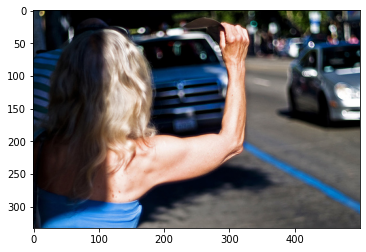

generated caption:

man with ears is wearing glasses and an orange hat
actual_captions:

blond woman in a blue shirt appears to wait for a ride
blond woman is on the street hailing a taxi
woman is signaling is to traffic as seen from behind
woman with blonde hair wearing a blue tube top is waving on the side of the street
woman in the blue dress is holding out her arm at oncoming traffic
|||||||||||||||||||


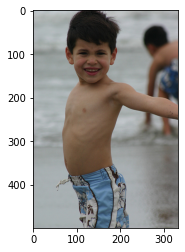

generated caption:

little girl climbing into a wooden
actual_captions:

boy in his blue swim shorts at the beach
boy smiles for the camera at a beach
young boy in swimming trunks is walking with his arms outstretched on the beach
playing on the beach
boy is playing on the shore of an ocean
|||||||||||||||||||


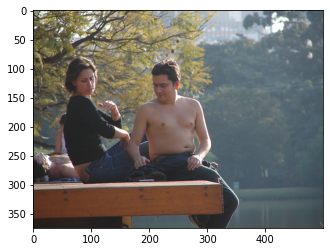

generated caption:

little girl climbing into a wooden
actual_captions:

lady and a man with no shirt sit on a dock
man and a woman are sitting on a dock together
man and a woman sitting on a dock
man and woman sitting on a deck next to a lake
shirtless man and a woman sitting on a dock
|||||||||||||||||||


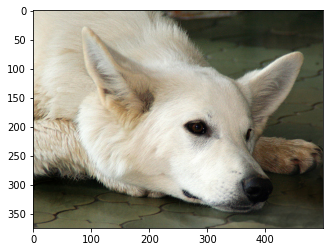

generated caption:

little girl climbing into a wooden
actual_captions:

closeup of a white dog that is laying its head on its paws
large white dog lying on the floor
white dog has its head on the ground
white dog is resting its head on a tiled floor with its eyes open
white dog rests its head on the patio bricks
|||||||||||||||||||


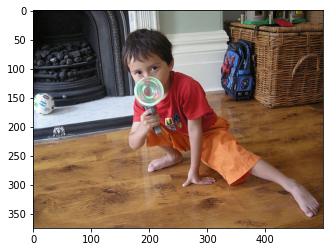

generated caption:

man with ears is wearing glasses and an orange hat
actual_captions:

boy with a toy gun
little boy in orange shorts playing with a toy
young boy with his foot outstretched aims a toy at the camera in front of a fireplace
young child plays with his new toy
with toy gun pointed at the camera
|||||||||||||||||||


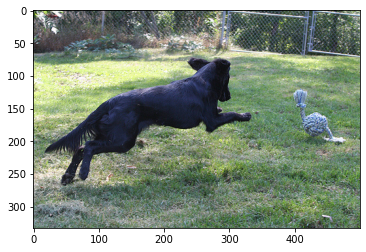

generated caption:

man with ears is wearing glasses and an orange hat
actual_captions:

black dog jumping to catch a rope
black dog playing fetch with a ball of rope
black dog pounces to get a rope toy
black dog running after his rope toy
large black dog is playing in a grassy yard
|||||||||||||||||||


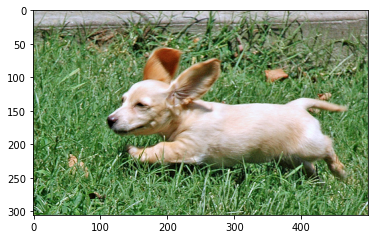

generated caption:

man with ears is wearing glasses and an orange hat
actual_captions:

little tan dog with large ears running through the grass
playful dog is running through the grass
small dogs ears stick up as it runs in the grass
small dog is running across the lawn
is a small beige dog running through a grassy
|||||||||||||||||||


In [158]:
 for i, pic in enumerate(test_text_data.keys()):
  pic_name = pic + '.jpg'
  x=plt.imread(os.path.join(root_direction,'Flicker/Flickr8k_Dataset/Flicker8k_Dataset', pic_name))
  plt.imshow(x)
  plt.show()
  print('generated caption:\n')
  print(generateCaption(test_ppi[pic_name], text_tokenizer, index2word))
  print("=====================")
  print('actual_captions:\n')
  for caption in test_text_data[pic]:
    print(caption[6:-6])
  print('|||||||||||||||||||')
  if i > 5:
    break

# Evaluation: BLEU Score

In [181]:
def evaluate_model(model, test_text_data, test_ppi, tokenizer, index2word):
  actual, predicted = list(), list()
  for index, pic in tqdm(enumerate(list(test_text_data.keys())[:-1])):
    pic_name = pic + '.jpg'
    actual_caption = test_text_data[pic][0].split()[1:-1]
    generated_caption = generateCaption(model,test_ppi[pic_name],tokenizer,index2word).split()
    actual.append(actual_caption)
    predicted.append(generated_caption)
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [182]:
evaluate_model(captioner, test_text_data, test_ppi, text_tokenizer, index2word)

1000it [08:53,  1.87it/s]
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.020160
BLEU-2: 0.141987
BLEU-3: 0.309992
BLEU-4: 0.376812
